## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#The number of times the new_page and treatment didn't match.
a=df.query("landing_page =='new_page' and group != 'treatment' ").shape[0]
#The number of times the old_page and control didn't match.
b=df.query("landing_page =='old_page' and group != 'control' ").shape[0]
#total mistaken values
a+b

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


none of the rows have missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.



In [8]:
#dropping the mistaken row
index_names=df[(df['landing_page']=='old_page') & (df['group']!='control')].index
df.drop(index_names,inplace=True)
index_names2=df[(df['landing_page']=='new_page') & (df['group']!='treatment')].index
df.drop(index_names2,inplace=True)
#storing the data in df2
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df**?

In [10]:
df['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df**.  What is it?

In [11]:
df[df.duplicated(subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df[df.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df**.

In [14]:
#dropping the duplicate
df=df.drop_duplicates(subset='user_id')

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#conversion rate regardless of the page
df['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#conversion rate for the control group
df[df['group']=='control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#conversion rate for the treatment group
df[df['group']=='treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
#percentage of the users who received the new page
df[df['landing_page']=='new_page'].shape[0]/df.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**It seems like the conversion ratio for the control group is slightly higher,
which means that that the old page has a slightly better chance of making a user convert,**
**But the difference is not great at all and might be just by chance.
so we need to run more tests to be certain**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The null hypothesis: the conversion rate of the old_page is greater equal to  the conversion rate of the new page.**<br><br>
**The alternative hypothesis: the conversion rate of the new page is greater than the conversion rate of the old page.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
#For the null hypothesis there is no diffrance in the conversion rate 
#between the old and the new page so
#we use to calculate the conversion rate of the new page
new_p=df['converted'].mean()
new_p

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
#For the null hypothesis there is no diffrance in the conversion rate 
#between the old and the new page so
#we use to calculate the conversion rate of the old page
old_p=df['converted'].mean()
old_p

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new=len(df[df['group']=='treatment'])
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old=len(df[df['group']=='control'])
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1,new_p,n_new)
new_page_converted.mean()

0.11770008946390476

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1,old_p,n_old)
old_page_converted.mean()

0.11904401338160993

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean()-old_page_converted.mean()

-0.0013439239177051726

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.binomial(1,new_p,n_new)
    old_page_converted = np.random.binomial(1,old_p,n_old)
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

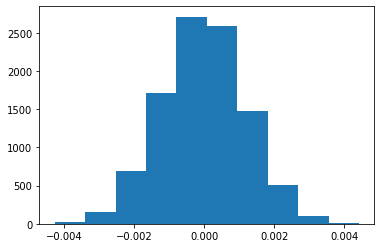

In [30]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
df_control = df.query('group == "control"')
df_treatment = df.query('group == "treatment"')
obs_diff = df_treatment['converted'].mean() - df_control['converted'].mean()
#the ovserved difference
obs_diff

-0.0015782389853555567

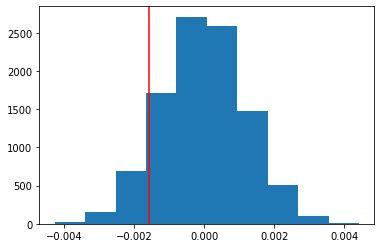

In [32]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r');


In [33]:
#the proportion of p_diffs greater than the observed difference.
(p_diffs > obs_diff).mean()

0.903

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**90% of the p_diffs are greater than the actual difference observed in the ab_data.csv <br><br>
this value is called the p_value and it represents the probability that an observed difference
could have occurred just by random chance.<br><br>
and with a 90% value, we cannot reject the null hypothesis as we don't have enough
evidence that the new_page has a higher conversion rate than the old_page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df.query('landing_page =="old_page" and converted==1').shape[0]
convert_new = df.query('landing_page =="new_page" and converted==1').shape[0]
n_old = df[df['landing_page']=='old_page'].shape[0]
n_new = df[df['landing_page']=='new_page'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [36]:
ztat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller' )
ztat, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**it means that we shouldn't reject the null that is the old page has an equal or greater conversion rate than the new one.<br><br>
with a large p_value of 0.905, we can't be sure the new page would have a higher rate.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**logistic regression since the depending variable is either a conversion or no conversion**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
#creating the intercept column.
df['intercept']=1
#creating the dummie variables  of the group column
df[['control','treatment']]=pd.get_dummies(df['group'])
#droping the control column
df= df.drop('control',axis=1)
# renaming treatment as ab_page
df= df.rename(columns={'treatment': 'ab_page'})
df.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
#importing the statsmodel library
import statsmodels.api as sm
#creating a model
model=sm.Logit(df['converted'],df[['intercept','ab_page']])
#fitting the model
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-09-13 16:13 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p_value for the ab_page is 19% because here in logistic regression we assumes an intercept and there might be differences in one or two-tailed testing**<br><br>
**Even tho the p_values differ but they both are greater than they should be which means that they both support the same conclusion that we shouldn't reject the null**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Other factors might have an effect on the user so we should take them into consideration**<br><br>
**But that also would make the model more complex so we should consider only what matters**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

Does it appear that country had an impact on conversion?  Provide the statistical output as well as a written response to answer this question.

In [40]:
country_data=pd.read_csv('countries.csv')
#preforming an inner join between the two dataframes on user_id
new_df=df.set_index('user_id').join(country_data.set_index('user_id'),how='inner')
new_df.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [41]:
new_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [42]:
#the average conversion rate
new_df.converted.mean()

0.11959708724499628

In [43]:
#the average conversion rate by country
new_df.groupby('country').converted.mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [44]:
#the average conversion rate by page
new_df.groupby('landing_page').converted.mean()

landing_page
new_page    0.118808
old_page    0.120386
Name: converted, dtype: float64

In [45]:
#creating dummie variables  for the countrys
new_df[['CA','UK','US']]=pd.get_dummies(new_df['country'])
new_df.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [46]:
#creating a new model
model=sm.Logit(new_df['converted'],new_df[['intercept','ab_page','CA','US']])
result=model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-09-13 16:16 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

**The country doesn't seem to have an affect on the conversion rate as the p_values are greater than 0.05**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
#mean conversion rate by country and landing_page
new_df.groupby(['ab_page','country']).converted.mean()

ab_page  country
0        CA         0.118783
         UK         0.120022
         US         0.120630
1        CA         0.111902
         UK         0.121171
         US         0.118466
Name: converted, dtype: float64

In [48]:
#creating new coloumns
new_df['uk_ab_page']= new_df['UK']*new_df['ab_page']
new_df['us_ab_page']= new_df['US']*new_df['ab_page']
#creating new model
model=sm.Logit(new_df['converted'],new_df[['intercept','ab_page','UK','uk_ab_page','US','us_ab_page']])
res=model.fit()
res.summary2()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-09-13 16:17 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
uk_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
us_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

**there seems to be no relation between page and country as the p_value are high and th the influence of the page is almost equal in all countries. 

# conclusions
**In conclusion based on A/B testing and regrission there in not enough evidence that the new page will have more converted users and there is also no evedande that the country has an affect on the conversion rate.**